In [307]:
# Config
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

What is the probability that a person who tested positive for vampirism is a vampire?

$$
\begin{aligned}
Pr(V|positive) & = \frac{Pr(positive|V)Pr(V)}{Pr(positive)} \\
Pr(positive) & = Pr(positive|V)Pr(V) + Pr(positive|M)(1-Pr(V)
\end{aligned}
$$

In [308]:
# Eg. Probability of Vampirism 

pr_positive_vampire = 0.95
pr_positive_mortal = 0.01
pr_vampire = 0.001

pr_positive = pr_positive_vampire*pr_vampire + (pr_positive_mortal*(1-pr_vampire))

pr_vampire_positive = (pr_positive_vampire * pr_vampire) / pr_positive

print(pr_vampire_positive)

0.08683729433272395


Wow, unintuitively low number given that if a test is positive that they're ACTUALLY a vampire (due to their low population??)

NOTE: Most people find this result counterintuitive. And it’s a very important result, because it mimics the structure of many realistic testing contexts, such as HIV and DNA testing, criminal profiling, and even statistical significance testing (see the Rethinking box at the end of this section). Whenever the condition of interest is very rare, having a test that finds all the true cases is still no guarantee that a positive result carries much information at all. The reason is that most positive results are false positives, even when all the true positives are detected correctly.

There is a way to present the same problem that does make it more intuitive, however. Suppose that instead of reporting probabilities, as before, I tell you the following:
(1) In a population of 100,000 people, 100 of them are vampires.
(2) Of the 100 who are vampires, 95 of them will test positive for vampirism. (3) Of the 99,900 mortals, 999 of them will test positive for vampirism.

Now tell me, if we test all 100,000 people, what proportion of those who test positive for vampirism actually are vampires? Many people, although certainly not all people, find this presentationaloteasier.49 Nowwecanjustcountupthenumberofpeoplewhotestpositive: 95 + 999 = 1094. Out of these 1094 positive tests, 95 of them are real vampires, so that implies:
Pr(vampire|positive) = 95/1094 ≈ 0.087

It’s exactly the same answer as before, but without a seemingly arbitrary rule.
The second presentation of the problem, using counts rather than probabilities, is often called the frequency format or natural frequencies.

### Sampling from a grid-approximate posterior

In [309]:
def grid_approx_posterior(grid_points, success, tosses):
    #Define the grid
    grid = np.linspace(0, 1, grid_points)
    
    #Repetitions
    prob_p = np.repeat(1, grid_points)
    
    likelihood = stats.binom.pmf(success, tosses, grid)
    
    unstd_posterior = prob_p * likelihood
    
    posterior = unstd_posterior / unstd_posterior.sum()
    
    return(grid, posterior)

    

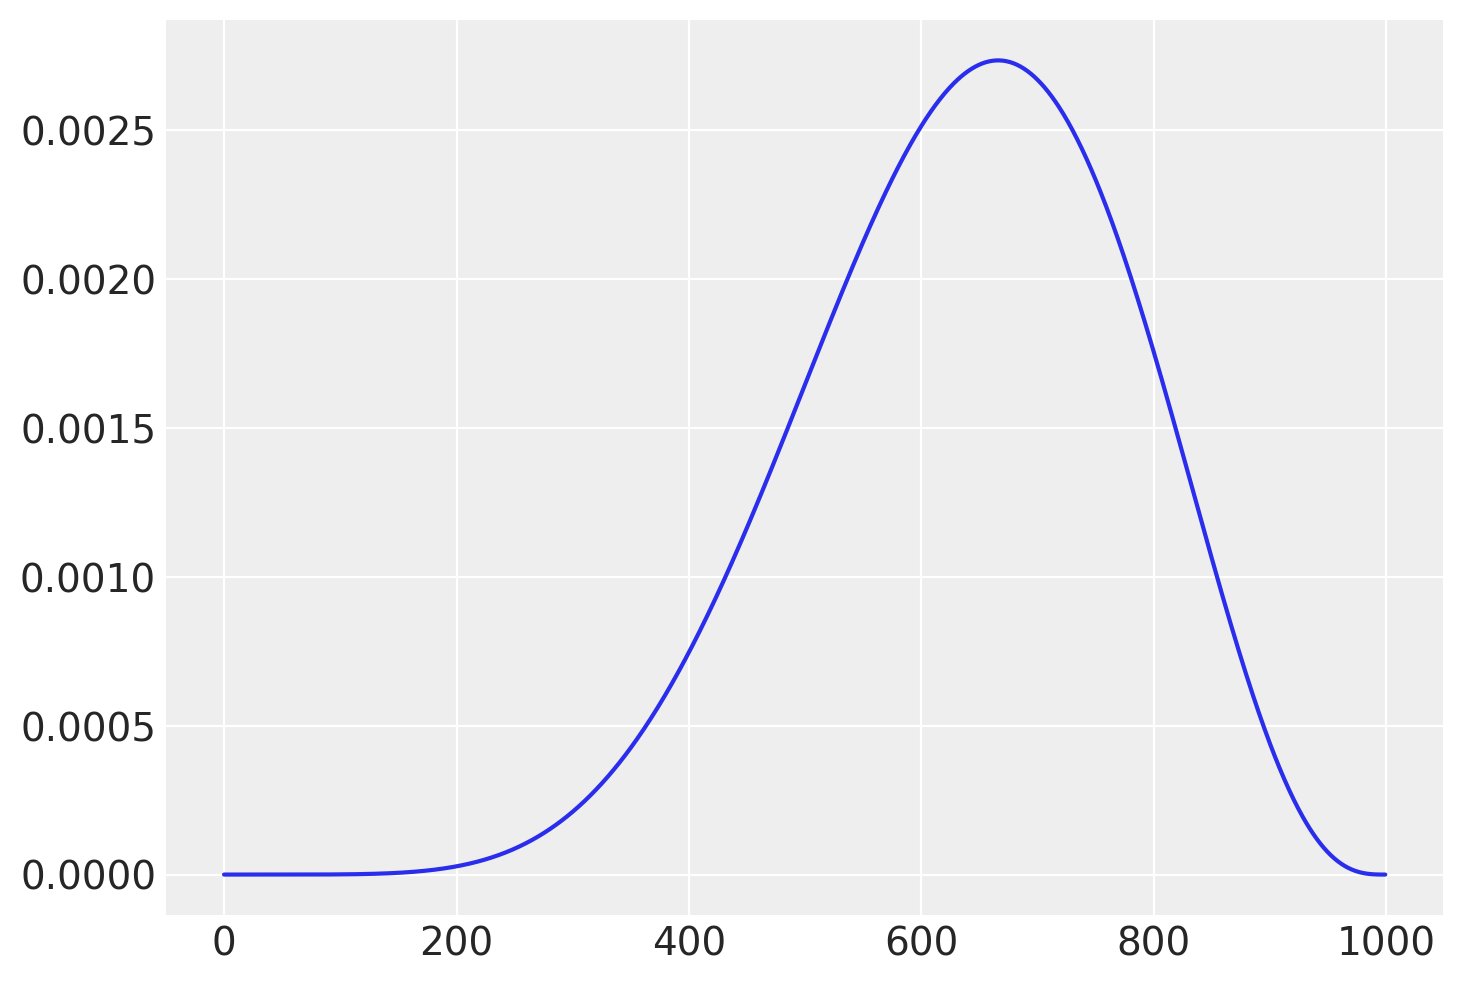

In [310]:
p_grid, posterior = grid_approx_posterior(1000, 6, 9)

plt.plot(posterior)

In [311]:
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

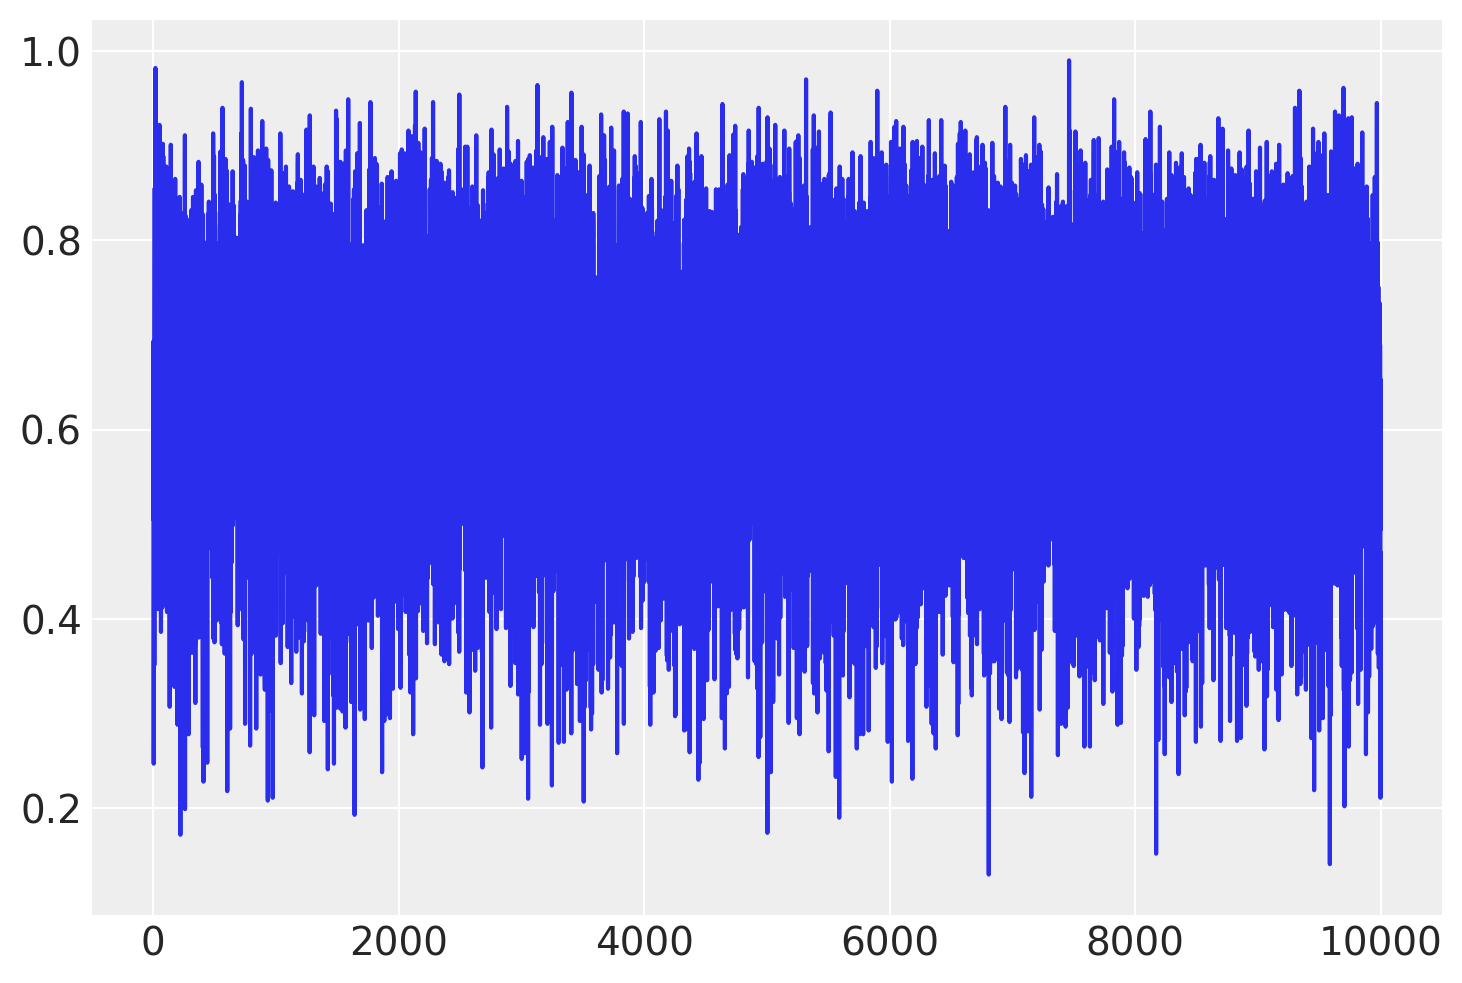

In [312]:
plt.plot(samples)

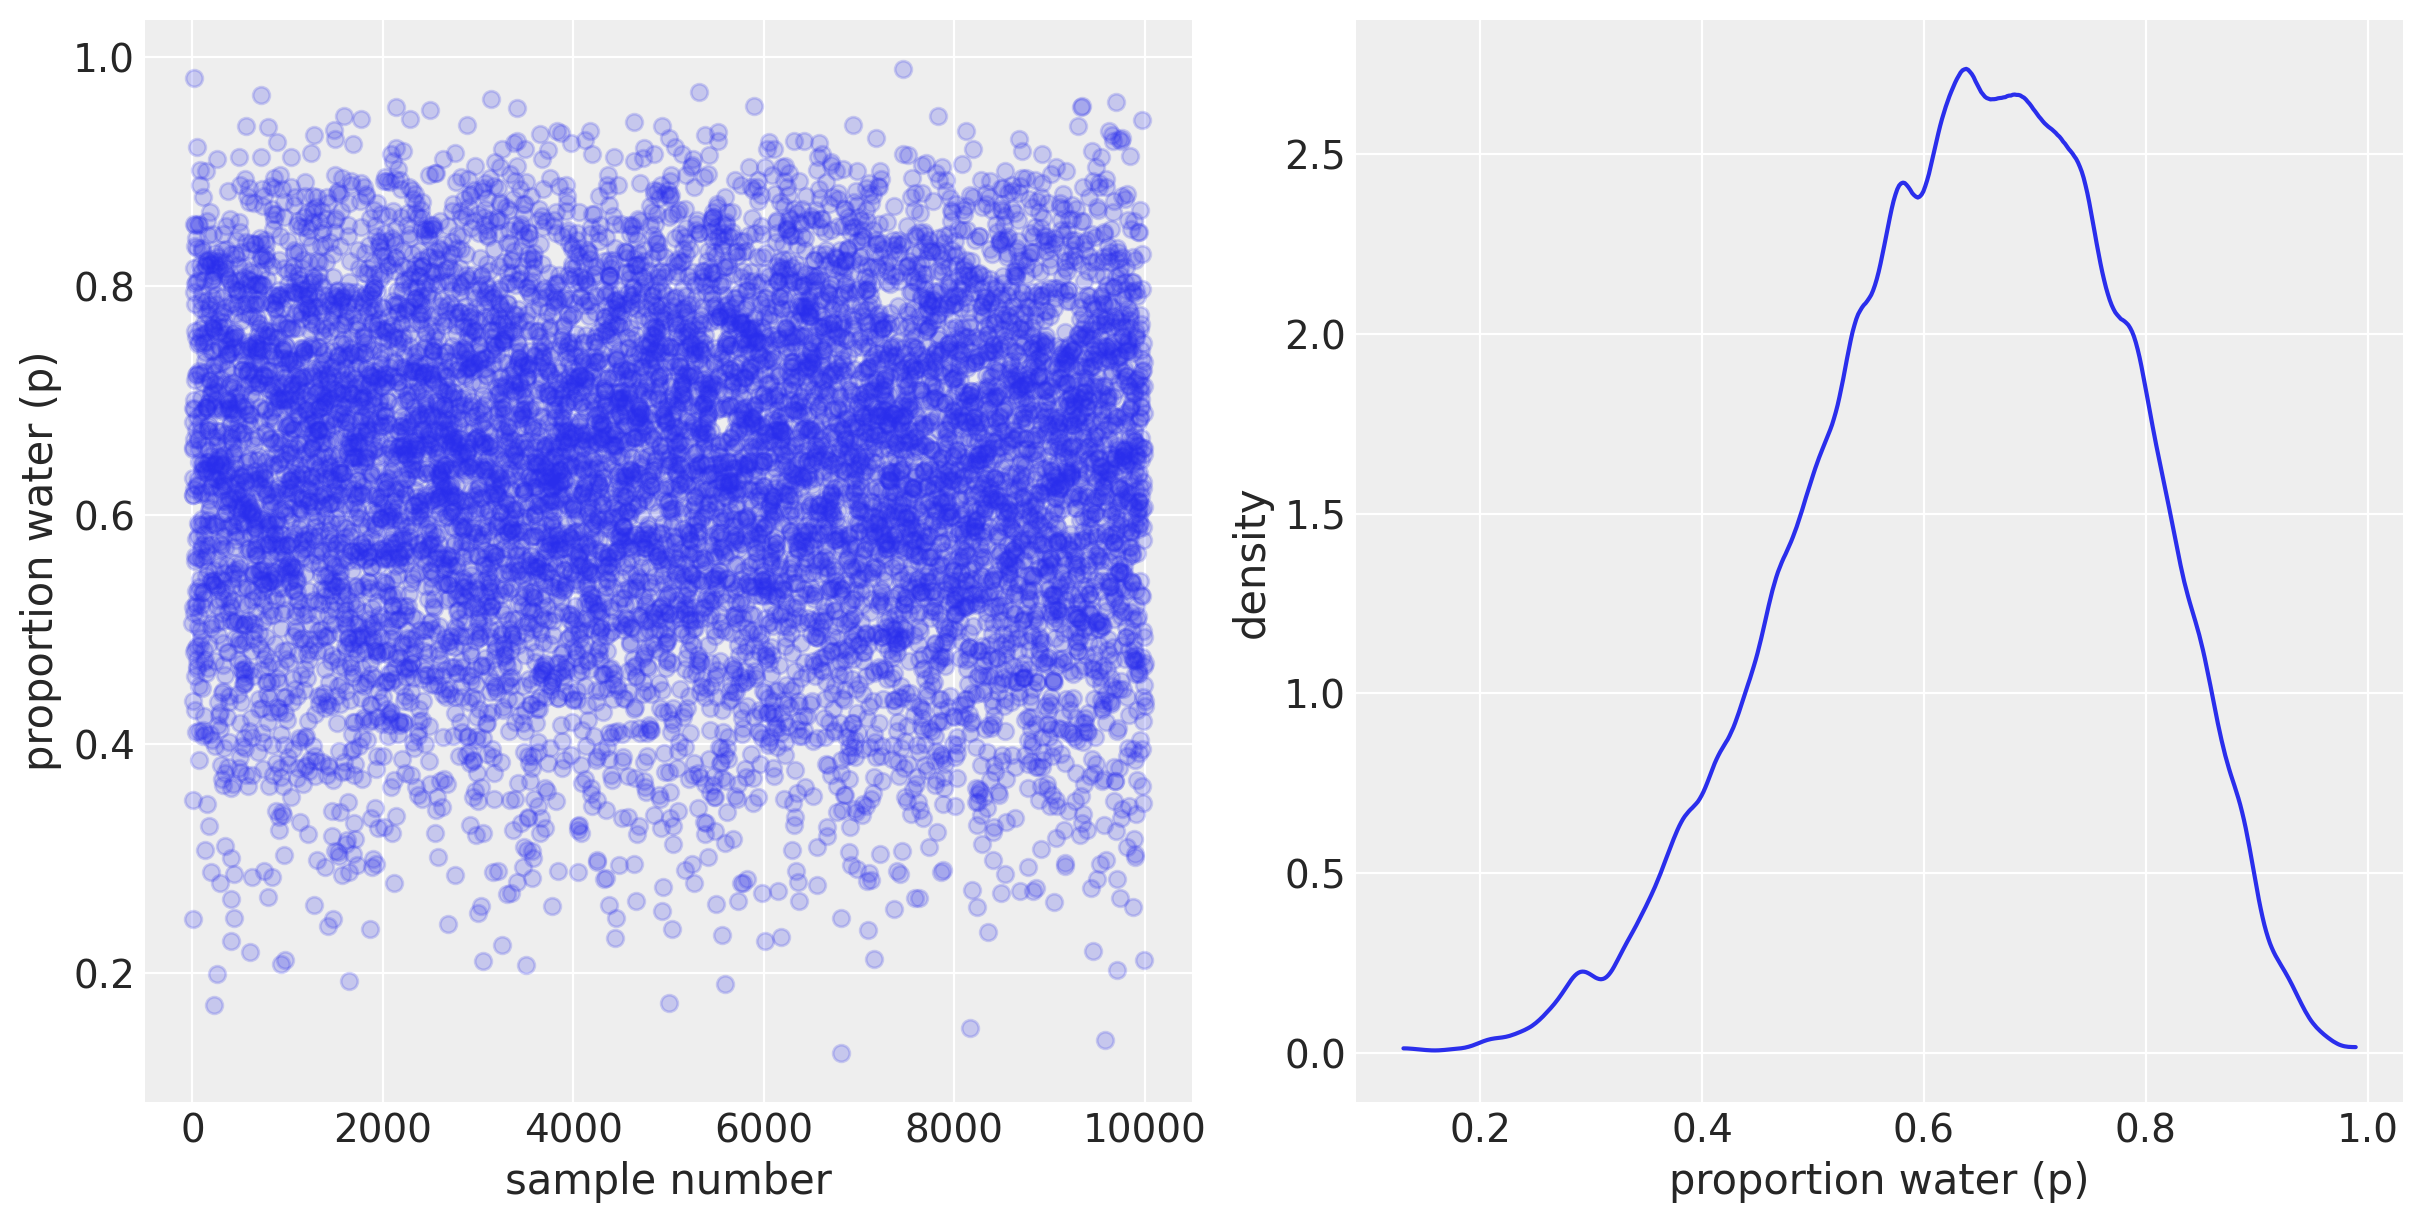

In [313]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.plot(samples, "o", alpha=0.2)
ax0.set_xlabel("sample number")
ax0.set_ylabel("proportion water (p)")
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel("proportion water (p)")
ax1.set_ylabel("density");

### Sampling to summarize
Once your model produces a posterior distribution, the model’s work is done. But your work has just begun.  It is necessary to summarize and interpret the posterior distribution. Exactly how it is summarized depends upon your purpose. But common questions include:

• How much posterior probability lies below some parameter value?

• How much posterior probability lies between two parameter values?

• Which parameter value marks the lower 5% of the posterior probability?

• Which range of parameter values contains 90% of the posterior probability? 

• Which parameter value has highest posterior probability?

#### 3.2.1 Intervals of defined boundaries
- Posterior probability that the proportion of water is less than 0.5

In [314]:
# Add up posterior probability where p < 0.5
sum(posterior[p_grid < 0.5])

0.17187458902022879

In [315]:
# Using samples from the posterior 
sum(samples < 0.5) / len(samples)

0.1699

In [316]:
# Fixed interval using samples 
sum((samples > 0.5) & (samples < 0.75)) / len(samples)

0.6031

#### 3.2.2 Intervals of defined mass 
It is more common to see scientific journals reporting an interval of defined mass, usually known as a CONFIDENCE INTERVAL. (COMPATIBILITY INTERVAL): an arbitrary range of parameter values compatible with the model and data.

In [317]:
# Boundaries of the lower 80% posterior probability
np.percentile(samples, 80)

0.7627627627627628

In [318]:
# Boundaries of the middle 80%
np.percentile(samples, [10, 90])

array([0.45045045, 0.81381381])

Percentile intervals do a good job comminucating the shape of a distribution as long as the distribution isn't TOO asymmetrical. Consider the posterior distribution and different intervals such as

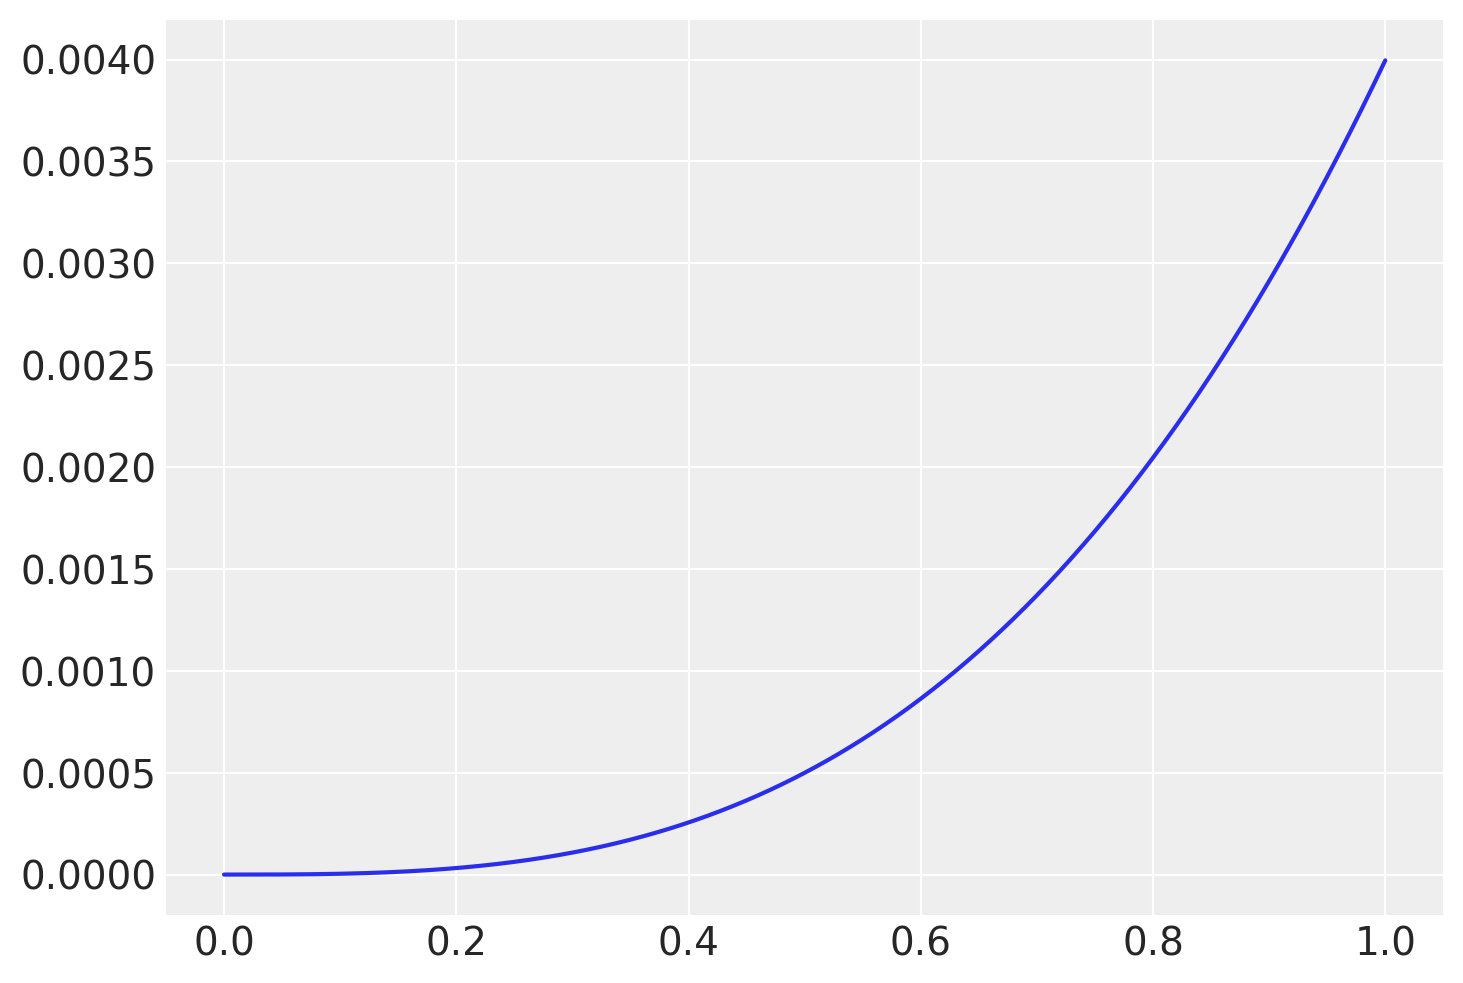

In [319]:
pr_grid, asym_posterior = grid_approx_posterior(1000, 3, 3)
samples2 = np.random.choice(pr_grid, p=asym_posterior, size=int(1e4), replace=True)
plt.plot(pr_grid, asym_posterior)

In [320]:
np.percentile(samples2, [25, 75])

array([0.70670671, 0.93093093])

In this example, it ends up excluding the most probable parameter values, near p = 1. So in terms of describing the shape of the posterior distribution—which is really all these intervals are asked to do—the percentile interval can be misleading.

HIGHEST POSTERIOR DENSITY INTERVAL (HPDI) is the narrowest interval containing the specified probability mass. There could be an infinite number of posterior intervals with the same mass but if you want an interval that best represents the parameter values most consistent with the data, then you want the densest of these intervals. 

In [321]:
az.hdi(samples2, hdi_prob=0.5)

array([0.84084084, 1.        ])

The HPDI also has some disadvantages. HPDI is more computationally intensive than PI and suffers from greater simulation variance, which is a fancy way of saying that it is sensitive to how many samples you draw from the posterior.

#### 3.2.3 Point Estimates
The third and final common summary task for the posterior is to produce point estimates of some kind. Given the entire posterior distribution, what value should you report? 

Suppose you report the parameter value wit hthe highest posterior probability, a maximum a posteriori (MAP) estimate:

In [322]:
pr_grid[asym_posterior == max(asym_posterior)]

array([1.])

In [323]:
stats.mode(samples2)[0]

array([0.96096096])

In [324]:
np.mean(samples2)

0.8003837837837838

In [325]:
np.median(samples2)

0.8408408408408409

One principled way to go beyond using the entire posterior as the estimate is to choose a loss function. A loss function is a rule that tells you the cost associated with using any particular point estimate. While statisticians and game theorists have long been interested in loss functions, and how Bayesian inference supports them, scientists hardly ever use them explicitly. The key insight is that different loss functions imply different point estimates.

Here’s an example to help us work through the procedure. Suppose I offer you a bet. Tell me which value of p, the proportion of water on the Earth, you think is correct. I will pay you $100, if you get it exactly right. But I will subtract money from your gain, proportional to the distance of your decision from the correct value. Precisely, your loss is proportional to the absolute value of d − p, where d is your decision and p is the correct answer. We could change the precise dollar values involved, without changing the important aspects of this problem. What matters is that the loss is proportional to the distance of your decision from the true value.

It turns out that the parameter value that maximizes expected winnings (minimizes expected loss) is the median of the posterior distribution. Let’s calculate that fact, without using a mathematical proof.

In [326]:
# Compute the weighted average loss
sum(asym_posterior * abs(0.5-pr_grid))

0.3128751874998122

In [327]:
# repeating this calculation for every possible decision

loss = [sum(asym_posterior * abs(d - pr_grid)) for d in pr_grid]
pr_grid[loss == min(loss)]

array([0.84084084])

So what are we to learn from all of this? In order to decide upon a point estimate, a single-value summary of the posterior distribution, we need to pick a loss function. Different loss functions nominate different point estimates. 

In [328]:
sum(posterior * abs(0.5-p_grid))

0.16406263699495907

In [329]:
loss = [sum(posterior * abs(d - p_grid)) for d in p_grid]
p_grid[loss == min(loss)]

array([0.64464464])

In [330]:
np.mean(samples)

0.6376734734734735

In [331]:
loss

[0.6363636363661918,
 0.6353626353651907,
 0.6343616343641902,
 0.633360633363189,
 0.6323596323621875,
 0.6313586313611868,
 0.6303576303601859,
 0.6293566293591855,
 0.6283556283581855,
 0.627354627357184,
 0.6263536263561846,
 0.6253526253551868,
 0.6243516243541919,
 0.6233506233532026,
 0.622349622352221,
 0.6213486213512505,
 0.6203476203502983,
 0.6193466193493743,
 0.6183456183484896,
 0.6173446173476587,
 0.6163436163469023,
 0.615342615346248,
 0.614341614345731,
 0.6133406133453924,
 0.6123396123452894,
 0.6113386113454852,
 0.6103376103460643,
 0.6093366093471283,
 0.6083356083487959,
 0.6073346073512129,
 0.6063336063545518,
 0.6053326053590181,
 0.6043316043648509,
 0.6033306033723328,
 0.6023296023817926,
 0.6013286013936111,
 0.6003276004082262,
 0.5993265994261425,
 0.5983255984479392,
 0.5973245974742755,
 0.5963235965058994,
 0.5953225955436596,
 0.5943215945885145,
 0.59332059364154,
 0.5923195927039471,
 0.5913185917770901,
 0.5903175908624796,
 0.5893165899617977,

### 3.3 Sampling to simulate prediction

Another common job for samples is to ease simulation of the model’s implied observations. Generating implied observations from a model is useful for at least four distinct reasons.

(1) Model design. We can sample not only from the posterior, but also from the prior. Seeing what the model expects, before the data arrive, is the best way to understand the implications of the prior. We’ll do a lot of this in later chapters, where there will be multiple parameters and so their joint implications are not always very clear.

(2) Model checking. After a model is updated using data, it is worth simulating implied observations, to check both whether the fit worked correctly and to investigate model behavior.

(3) Software validation. In order to be sure that our model fitting software is working, it helps to simulate observations under a known model and then attempt to recover the values of the parameters the data were simulated under.

(4) Research design. If you can simulate observations from your hypothesis, then you can evaluate whether the research design can be effective. In a narrow sense, this means doing power analysis, but the possibilities are much broader.

(5) Forecasting. Estimates can be used to simulate new predictions, for new cases and future observations. These forecasts can be useful as applied prediction, but also for model criticism and revision.

#### 3.3.1 Dummy Data

Let’s summarize the globe tossing model that you’ve been working with for two chapters now. A fixed true proportion of water p exists, and that is the target of our inference. Tossing the globe in the air and catching it produces observations of “water” and “land” that appear in proportion to p and 1 − p, respectively.

- Bayesian models are always _generative_ capable of simulating predictions
- Call such simulated data DUMMY DATA to indicate that it is a stand-in for actual data. With the globe tossing model, the dummy data arises from a binomial likelihood

$ W: \text{observed count of Water} $

$ N: \text{number of tosses} $

$$
\begin{aligned}
Pr(W|N,p) = \frac{N!}{W!(N-W)!}p^W(1-p)^{N-W}
\end{aligned}
$$

For N = 2, there are only 3 possibilities: 0, 1 or 2 water. We can compute the probability of each for any given value of p. E.g. p = 0.7

In [332]:
# N = 2, probability = 0.7
pr_water_n2 = stats.binom.pmf(range(3), 2, 0.7)

In [333]:
print(pr_water_n2)

[0.09 0.42 0.49]


This means that there’s a 9% chance of observing w = 0, a 42% chance of w = 1, and a 49% chance of w = 2. If you change the value of p, you’ll get a different distribution of implied observations.

In [334]:
pr_water_n21 = stats.binom.pmf(range(3), 2, 0.85)
print(pr_water_n21)

[0.0225 0.255  0.7225]


Now to simulate observations using these probabilities.

In [335]:
binom_dummy_data = stats.binom.rvs(n=2, p=0.7, size=1)
print(binom_dummy_data)

[1]


In [336]:
# A set of 10 simulations instead of 1
binom_dummy_data = stats.binom.rvs(n=2, p=0.7, size=10)
print(binom_dummy_data)

[2 2 1 1 1 2 2 0 2 1]


In [337]:
# Generate 100,000 dummy observations
dummy_w1 = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
[(dummy_w1 == i).mean() for i in range(3)]
        

[0.09088, 0.42142, 0.4877]

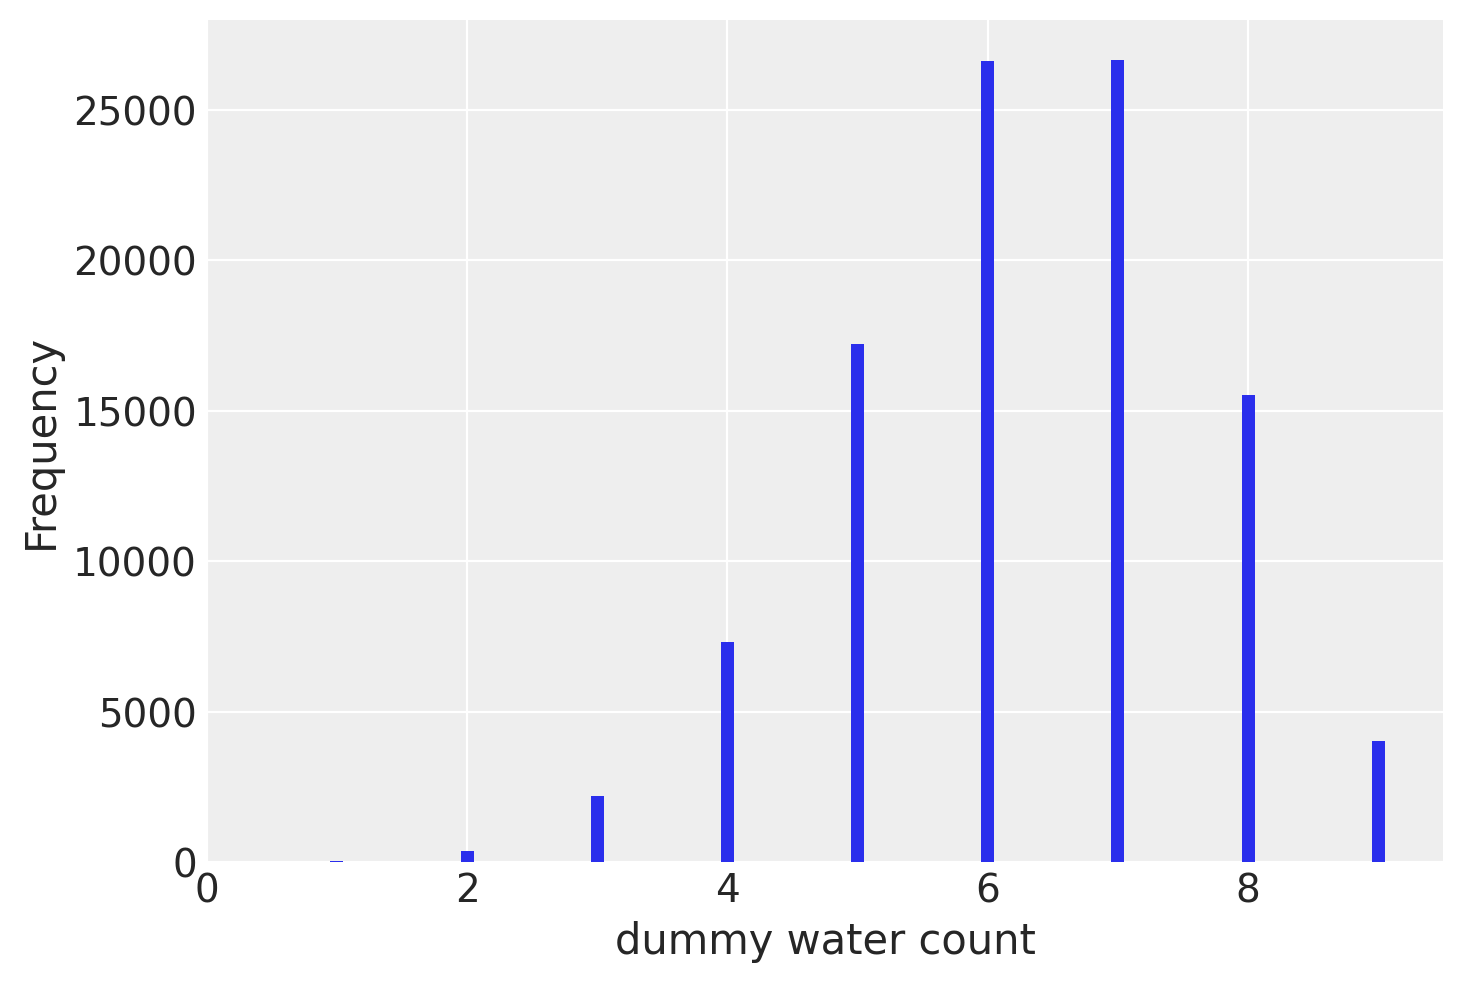

In [338]:
# 9 tosses instead of 2 tosses
dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))
bar_width = 0.1
plt.hist(dummy_w, bins=np.arange(0, 11) - bar_width / 2, width=bar_width)
plt.xlim(0, 9.5)
plt.xlabel("dummy water count")
plt.ylabel("Frequency");

#### 3.3.2 Model Checking
- ensuring the model fitting worked correctly
- evaluating the adequacy of a model for some purpose

##### 3.3.2.1 Did the software work? 
Inthesimplestcase,wecancheckwhetherthesoftware worked by checking for correspondence between implied predictions and the data used to fit the model

##### 3.3.2.2 Is the model adquate? 
After assessing whether the posterior distribution is the correct one, because the software worked correctly, it’s useful to also look for aspects of the data that are not well described by the model’s expectations. The goal is not to test whether the model’s assumptions are “true,” because all models are false. Rather, the goal is to assess exactly how the model fails to describe the data, as a path towards model comprehension, revision, and improvement.

For now, we need to learn how to combine sampling of simulated observations, as in the previous section, with sampling parameters from the posterior distribution.

Observation uncertainty: 
For any unique value of for the probability parameter p, there is a unique implied pattern of observation that the model expects. Even if you know p for certain, you won't know the result of a globe toss with certainty (unless p = 0 or p = 1)

Probability, p, uncertainty: the posterior distribution over p showcases this uncertainty and since there is uncertainty, everything else is uncertain as it is dependent on p. 

Could we compute the sampling distribution of outcomes at each value of p? Then we could average all of these prediction distribution together, at each posterior probability of p, to get POSTERIOR PREDICTIVE DISTRIBUTION. 

The resulting distribution is used for predictions but it incorporates all of the uncertainty emobided in the posterior distribution for the parameter p.

In [339]:
# propagating parameter uncertainty by
# replacing fixed probability with sample data

w = stats.binom.rvs(n=9, size=int(1e4), p=samples)

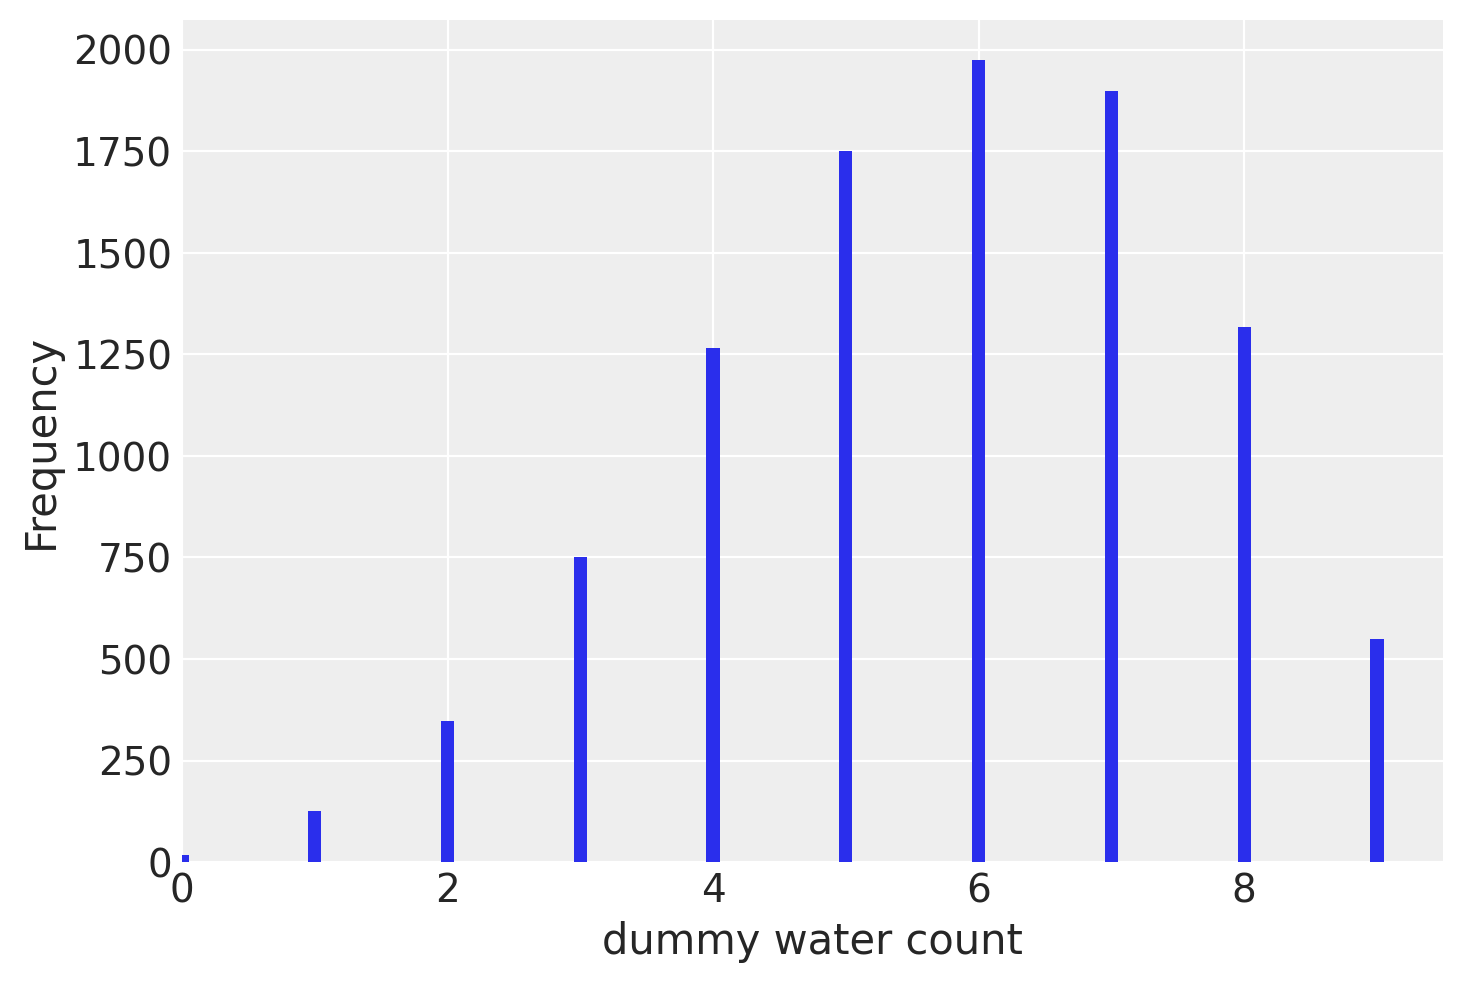

In [340]:
bar_width = 0.1
plt.hist(w, bins=np.arange(0, 11) - bar_width / 2, width=bar_width)
plt.xlim(0, 9.5)
plt.xlabel("dummy water count")
plt.ylabel("Frequency");

In [341]:
# Model may seem perfect but lets look at where the model could fail
# First, lets consider the length of the longest run of either W or L
# W L W W W L W L W 
# Longest run is 3
# Another measure of correlation between samples is the switches 
# from water to land
# Number of switches is 6